# Deep Q-Network (DQN)

---

In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

<br>

# 1. Import the Packages

---

In [1]:
# Import the libraries
import gym
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import the PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

<br>

# 2. Get the Environment

---

Initialize the environment in the code cell below.

In [3]:
# Initialize the evironment
env = gym.make('LunarLander-v2')

In [4]:
# Set the seed for randomness
env.seed(0)

[0]

In [5]:
# Get the shape of state
print('State shape: ', env.observation_space.shape)

# Get the number of actions
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


<br>

# 3. DQN Agent

---

Initialize the agent in the code cell below.

In [6]:
# Q-Network Class
class QNetwork(nn.Module):
    """
    Actor (Policy) Model.
    
    """
    
    # Init function
    def __init__(self, state_size, action_size, seed, fc1_units = 64, fc2_units = 64):
        """
        Initialize parameters and build model.
        
        PARAMETERS
        ---------------------------------
            - state_size (int):    Dimension of each state
            - action_size (int):   Dimension of each action
            - seed (int):          Random seed
            - fc1_units (int):     Number of nodes in first hidden layer
            - fc2_units (int):     Number of nodes in second hidden layer
        """
        # TODO
        super(QNetwork, self).__init__()
        
        # Set the seed for generating random numbers
        self.seed = torch.manual_seed(seed)
        
        # First fully connected layer 
        self.fc1 = nn.Linear(state_size, fc1_units)
        
        # Second fully connected layer 
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        
        # Third fully connected layer 
        self.fc3 = nn.Linear(fc2_units, action_size)

    # Forward pass function
    def forward(self, state):
        """
        Build a network that maps state -> action values.
        
        PARAMETERS
        ---------------------------------
            - state: Hidden state
        """
        # Apply RELU to first FCL
        x = F.relu(self.fc1(state))
        
        # Apply RELU to second FCL
        x = F.relu(self.fc2(x))
        
        # Get the third FCL
        x = self.fc3(x)
        
        return x

In [7]:
### Hyperparameters

# Replay buffer size
BUFFER_SIZE = int(1e5) 

# Minibatch size
BATCH_SIZE = 64         

# Discount factor
GAMMA = 0.99            

# For soft update of target parameters
TAU = 1e-3              

# Learning rate 
LR = 5e-4               

# How often to update the network
UPDATE_EVERY = 4        

In [8]:
# Set the device type (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Q-Network Agent Class
class Agent():
    """
    Interacts with and learns from the environment.
    
    """
    
    # Init function
    def __init__(self, state_size, action_size, seed):
        """
        Initialize an Agent object.
        
        PARAMETERS
        -------------------------
            - state_size (int):  Dimension of each state
            - action_size (int): Dimension of each action
            - seed (int):        Random seed
        """
        # The state size object
        self.state_size = state_size
        
        # The action size object
        self.action_size = action_size
        
        # The seed object
        self.seed = random.seed(seed)
        
        # The Q-Network Local object
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        
        # The Q-Network Target object
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        # The optimizer object
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)

        # The replay memory object
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # The time step object (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    
    # Step function
    def step(self, state, action, reward, next_state, done):
        """
        Step function.
        
        PARAMETERS
        -------------------------
            - state
            - action
            - reward
            - next_state 
            - done
        """
        # Append experience (S,A,R,S',done) into replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Every UPDATE_EVERY time
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            
            # If length of replay memory gets larger than batch size
            if len(self.memory) > BATCH_SIZE:
                
                # Get a random subset
                experiences = self.memory.sample()
                
                # Learn
                self.learn(experiences, GAMMA)

                
    # Act function
    def act(self, state, eps=0.):
        """
        Returns actions for given state as per current policy.
        
        PARAMETERS
        -------------------------
            - state (array_like): Current state
            - eps (float):        Epsilon, for epsilon-greedy action selection
        """
        # Get the state in a proper type
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # TODO
        self.qnetwork_local.eval()
        
        # Disable gradient calculation
        with torch.no_grad():
            
            # TODO
            action_values = self.qnetwork_local(state)
            
        # TODO
        self.qnetwork_local.train()

        ### Epsilon-greedy action selection
        # If random number larger than epsilon
        if random.random() > eps:
            
            # Get the index of the maximum value in action values
            return np.argmax(action_values.cpu().data.numpy())
        
        # If random number less than epsilon
        else:
            
            # Randomely choose in action values
            return random.choice(np.arange(self.action_size))

        
    # Learn function
    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.

        PARAMETERS
        -------------------------
            - experiences (Tuple[torch.Tensor]):  Tuple of (s, a, r, s', done) tuples 
            - gamma (float):                      Discount factor
        """
        # Get the expriences (S,A,R,S',done)
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

        
    # Soft update function
    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters.
        
                        θ_target = τ*θ_local + (1 - τ)*θ_target

        PARAMETERS
        -------------------------
            - local_model (PyTorch model):   Weights will be copied from
            - target_model (PyTorch model):  Weights will be copied to
            - tau (float):                   Interpolation parameter 
        """
        # Iterate through target model & local model
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            
            # Get the soft update formula
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [10]:
# Replay Buffer Class
class ReplayBuffer:
    """
    Fixed-size buffer to store experience tuples.
    
    """

    # Init function
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a ReplayBuffer object.

        PARAMETERS
        -------------------------
            - action_size (int):  Dimension of each action
            - buffer_size (int):  Maximum size of buffer
            - batch_size (int):   Size of each training batch
            - seed (int):         Random seed
        """
        # The action size object
        self.action_size = action_size
        
        # The memory object
        self.memory = deque(maxlen = buffer_size)  
        
        # The batch size object
        self.batch_size = batch_size
        
        # The exprience object
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        # The seed object
        self.seed = random.seed(seed)
    
    
    # Add function
    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory.
        
        PARAMETERS
        -------------------------
            - state
            - action
            - reward
            - next_state
            - done
        """
        # Get the exprience
        e = self.experience(state, action, reward, next_state, done)
        
        # Append the exprience into memory
        self.memory.append(e)
    
    
    # Sample function
    def sample(self):
        """
        Randomly sample a batch of experiences from memory.
        
        """
        # Get a random batch of exprience
        experiences = random.sample(self.memory, k = self.batch_size)
    
        # Get the state in proper type
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        
        # Get the action in proper type
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        
        # Get the reward in proper type
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        
        # Get the next state in proper type
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        # Get the done in proper type
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        # Return the (S,A,R,S',done)
        return (states, actions, rewards, next_states, dones)


    # Function for getting the memory size
    def __len__(self):
        """
        Return the current size of internal memory.
        
        """
        # Length of memory
        return len(self.memory)

In [11]:
# Initialize the agent
agent = Agent(state_size = 8, action_size = 4, seed = 0)

<br>

# 4. Watch an Un-Trained Agent

---

In [12]:
# Iterate through episodes
for i in range(1):
    
    # Get the state
    state = env.reset()
    
    # Iterate through the allowed timesteps per episode
    for j in range(200):
        
        # Get the action
        action = agent.act(state)
        
        # Render the environment
        env.render()
        
        # Run one timestep of the environment's dynamics
        state, reward, done, _ = env.step(action)
        
        # If terminal state
        if done:
            
            # Break
            break 

# Close the environment
env.close()

<br>

# 5. Train the Agent with DQN

---

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [13]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    
    PARAMETERS
    -------------------------
        - n_episodes (int):   Maximum number of training episodes
        - max_t (int):        Maximum number of timesteps per episode
        - eps_start (float):  Starting value of epsilon, for epsilon-greedy action selection
        - eps_end (float):    Minimum value of epsilon
        - eps_decay (float):  Multiplicative factor (per episode) for decreasing epsilon
    """
    # Initialize a empty list for getting scores from each episode
    scores = []                        
    
    # Last 100 scores
    scores_window = deque(maxlen=100)  
    
    # Initialize scores
    eps = eps_start                    
    
    # Iterate through episodes
    for i_episode in range(1, n_episodes+1):
        
        # Get the state
        state = env.reset()
        
        # Initialize the score to zero
        score = 0
        
        # Iterate through allowed timesteps per episode
        for t in range(max_t):
            
            # Choose the action
            action = agent.act(state, eps)
            
            # Run one timestep of the environment's dynamics
            next_state, reward, done, _ = env.step(action)
            
            # TODO
            agent.step(state, action, reward, next_state, done)
            
            # Update the state
            state = next_state
            
            # Append the reward to score
            score += reward
            
            # If terminal state
            if done:
                
                # Break
                break 
                
        # Save the most recent score
        scores_window.append(score)       
        
        # Save most the score
        scores.append(score)    
        
        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps) 
        
        # Print the episode & average score (then remove)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Every 100 episodes
        if i_episode % 100 == 0:
            
            # Print the episode & average score
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        # If average of the most recent score is larger than 200
        if np.mean(scores_window) >= 200.0:
            
            # Print the solved message
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            # Save the weights
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            
            # Break
            break
            
    return scores

In [14]:
# Initialize the DQN
scores = dqn()

Episode 100	Average Score: -183.04
Episode 200	Average Score: -94.258
Episode 300	Average Score: -52.02
Episode 400	Average Score: 49.682
Episode 500	Average Score: 137.11
Episode 600	Average Score: 193.46
Episode 635	Average Score: 201.07
Environment solved in 535 episodes!	Average Score: 201.07


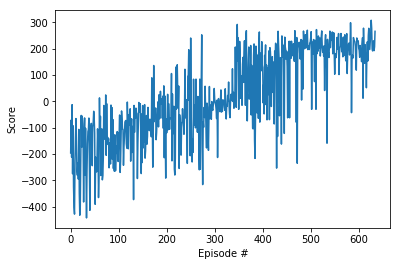

In [15]:
# Visualize the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

<br>

# 6. Watch a Smart Agent!

---

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [16]:
# Load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# Iterate through episodes
for i in range(10):
    
    # Get the state
    state = env.reset()
    
    # Iterate through the allowed timesteps per episode
    for j in range(200):
        
        # Get the action
        action = agent.act(state)
        
        # Render the environment
        env.render()
        
        # Run one timestep of the environment's dynamics
        state, reward, done, _ = env.step(action)
        
        # If terminal state
        if done:
            
            # Break
            break 

# Close the environment
env.close()

<br>

# 5. Explore

---

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  